Import all the Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

Set all the Constants

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

Import data into tensorflow dataset object

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names
CHANNELS=3
EPOCHS=50

In [6]:
len(dataset)

68

In [7]:
68*32

2176

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 0 0 0 1 2 2 0 2 1 0 0 0 0 0 0 0 1 1 1 1 0 0 2 1 0 1 0 0]


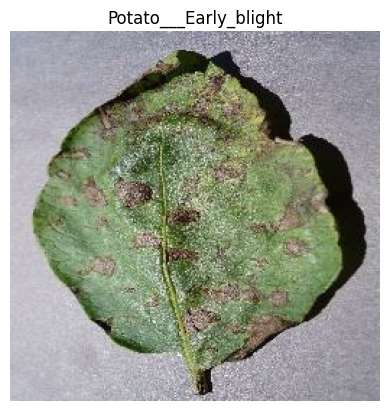

In [9]:
#for first image
for image_batch,lebel_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[lebel_batch[0]])
    plt.axis("off")

Visualize some of the images from our dataset

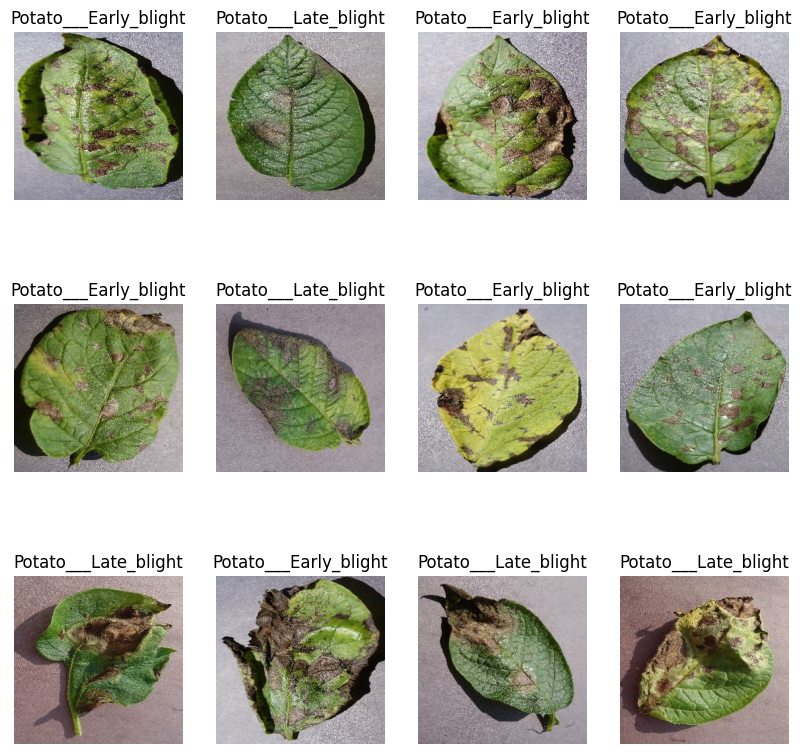

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

1.Training: Dataset to be used while training(80%)

2.Validation: Dataset to be tested against while training(10%)

3.Test: Dataset to be tested against after we trained a model(10%)

In [11]:
train_size=0.8
# dataset.take(10)
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

8

Cache, Shuffle, and Prefetch the Dataset

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model

In [23]:
#Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation

In [24]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architecture

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

Compiling the Model

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 138s 2s/step - loss: 0.8819 - accuracy: 0.4925 - val_loss: 0.7391 - val_accuracy: 0.6302
Epoch 2/50
54/54 [==============================] - 123s 2s/step - loss: 0.5085 - accuracy: 0.7662 - val_loss: 0.4551 - val_accuracy: 0.7812
Epoch 3/50
54/54 [==============================] - 1575s 13s/step - loss: 0.3709 - accuracy: 0.8501 - val_loss: 0.3324 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 131s 2s/step - loss: 0.2506 - accuracy: 0.9005 - val_loss: 0.4525 - val_accuracy: 0.8333
Epoch 5/50
54/54 [==============================] - 137s 3s/step - loss: 0.2087 - accuracy: 0.9132 - val_loss: 0.5263 - val_accuracy: 0.7969
Epoch 6/50
54/54 [==============================] - 174s 3s/step - loss: 0.2031 - accuracy: 0.9248 - val_loss: 0.2322 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 138s 3s/step - loss: 0.1968 - accuracy: 0.9259 - val_loss: 0.2027 - val_accuracy: 0.9219
Epoch 8/50


In [30]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 8s 685ms/step - loss: 0.0523 - accuracy: 0.9883


In [31]:
scores

[0.05231693387031555, 0.98828125]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
len(history.history['accuracy'])

50

In [36]:
history.history['accuracy']


[0.49247685074806213,
 0.7662037014961243,
 0.8501157164573669,
 0.9004629850387573,
 0.9131944179534912,
 0.9247685074806213,
 0.9259259104728699,
 0.9456018805503845,
 0.9548611044883728,
 0.9670138955116272,
 0.9664351940155029,
 0.9600694179534912,
 0.9710648059844971,
 0.9548611044883728,
 0.9780092835426331,
 0.9762731194496155,
 0.9774305820465088,
 0.9849537014961243,
 0.9878472089767456,
 0.9826388955116272,
 0.9890046119689941,
 0.9809027910232544,
 0.9832175970077515,
 0.9820601940155029,
 0.9791666865348816,
 0.9826388955116272,
 0.9884259104728699,
 0.9756944179534912,
 0.9861111044883728,
 0.9884259104728699,
 0.9861111044883728,
 0.9930555820465088,
 0.9814814925193787,
 0.9924768805503845,
 0.9901620149612427,
 0.984375,
 0.9878472089767456,
 0.9924768805503845,
 0.9884259104728699,
 0.9832175970077515,
 0.9907407164573669,
 0.9901620149612427,
 0.9872685074806213,
 0.9762731194496155,
 0.9866898059844971,
 0.9890046119689941,
 0.9872685074806213,
 0.9872685074806213,
 

In [37]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8818721175193787,
 0.5084531307220459,
 0.3708837628364563,
 0.25056442618370056,
 0.2087133675813675]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

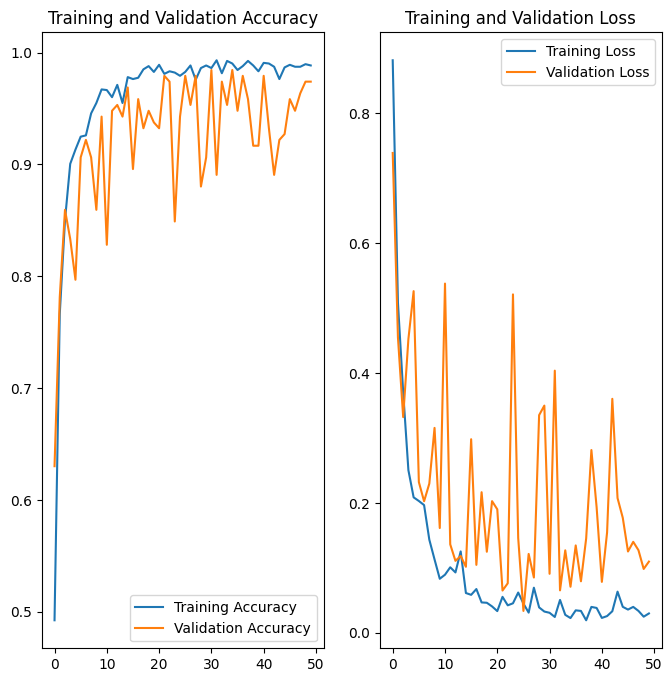

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 1s 1s/step
predicted label: Potato___healthy


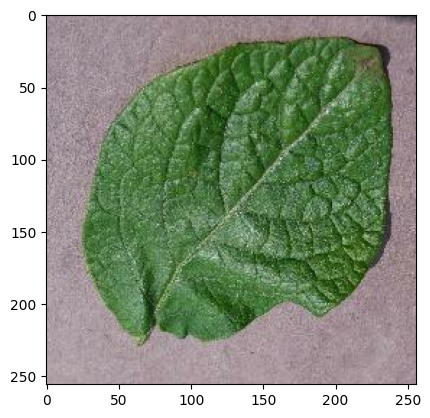

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference